In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path
print(torch.__version__)

2.3.1+cu118


In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout(0.10)
        self.dp2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [3]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        loss = F.nll_loss(model(X), y)
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

In [4]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()
            pred = pred_prob.argmax(dim=1, keepdim=True)
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

In [5]:
def create_data_folder():
    current_dir = Path.cwd()
    # parent_dir = current_dir.parent
    data_folder = current_dir / 'data'
    data_folder.mkdir(exist_ok=True)
create_data_folder()

In [6]:
train_dataloader = torch.utils.data.DataLoader(
                datasets.MNIST('data',
                                train=True,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1302,),(0.3069,))
                                ])),
                batch_size=32, shuffle=True
                )

test_dataloader = torch.utils.data.DataLoader(
                datasets.MNIST('data',
                                train=False,
                                download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1302,),(0.3069,))
                                ])),
                batch_size=500, shuffle=False
                )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:35<00:00, 281312.71it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 129179.85it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 445605.27it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4533681.29it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [7]:
torch.manual_seed(0)
device = torch.device('cpu')
model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

for epoch in range(1,3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)


epoch: 1 [0/60000 (0%)]	 training loss: 2.311839
epoch: 1 [320/60000 (1%)]	 training loss: 1.866824
epoch: 1 [640/60000 (1%)]	 training loss: 1.082228
epoch: 1 [960/60000 (2%)]	 training loss: 0.880526
epoch: 1 [1280/60000 (2%)]	 training loss: 0.838555
epoch: 1 [1600/60000 (3%)]	 training loss: 0.496232
epoch: 1 [1920/60000 (3%)]	 training loss: 0.436633
epoch: 1 [2240/60000 (4%)]	 training loss: 0.394346
epoch: 1 [2560/60000 (4%)]	 training loss: 0.454175
epoch: 1 [2880/60000 (5%)]	 training loss: 0.388366
epoch: 1 [3200/60000 (5%)]	 training loss: 0.496029
epoch: 1 [3520/60000 (6%)]	 training loss: 0.295328
epoch: 1 [3840/60000 (6%)]	 training loss: 0.427557
epoch: 1 [4160/60000 (7%)]	 training loss: 0.564096
epoch: 1 [4480/60000 (7%)]	 training loss: 0.360088
epoch: 1 [4800/60000 (8%)]	 training loss: 0.614586
epoch: 1 [5120/60000 (9%)]	 training loss: 0.166789
epoch: 1 [5440/60000 (9%)]	 training loss: 0.310312
epoch: 1 [5760/60000 (10%)]	 training loss: 0.110744
epoch: 1 [6080/60

In [8]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

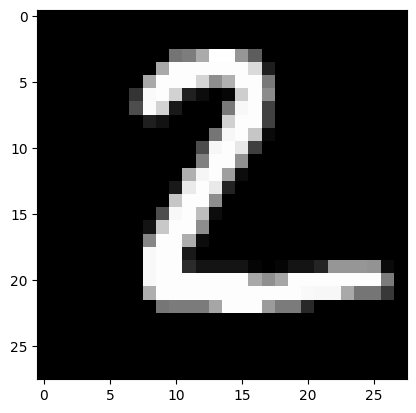

In [12]:
plt.imshow(sample_data[1][0],
           cmap='gray', interpolation='none')

In [18]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][1]}")
print(f"Ground Truth is : {sample_targets[1]}")

Model prediction is : 2
Ground Truth is : 2


In [19]:
PATH_TO_MODEL = "./covnet.pth"
torch.save(model.state_dict(), PATH_TO_MODEL)